# 1D Hubbard model

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import meanfi
import kwant
from meanfi.kwant_helper import utils

In [22]:
from helper import s0, sx, sy, sz, sigmas
from helper import rotate_quantization_axis

### Build the non-interacting system

In [23]:
lat = kwant.lattice.chain(norbs=2)

# The system is translational invariant, and we need to specify the vector
num_sites = 2
sys = kwant.Builder(kwant.TranslationalSymmetry(lat.vec([num_sites])))

for x in range(num_sites):
    sys[lat(x)] = 0 * s0
        
sys[lat.neighbors()] = 1.0 *s0

h_0 = utils.builder_to_tb(sys)

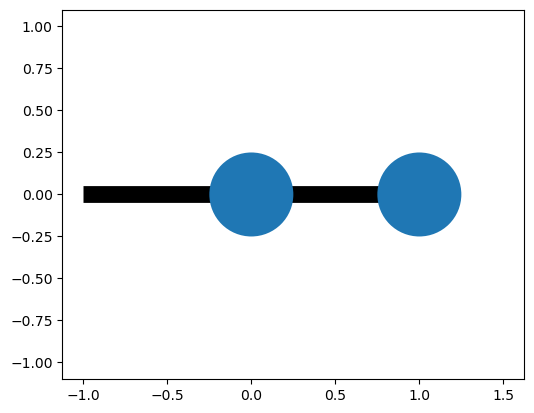

In [24]:
kwant.plot(sys);

### Check the non-interacting dispersion relation

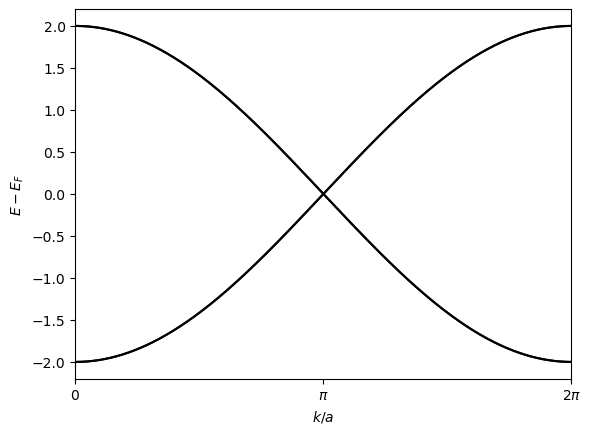

In [25]:
nk = 500  # number of k-points
ks = np.linspace(0, 2 * np.pi, nk, endpoint=False)
hamiltonians_0 = meanfi.tb_to_kgrid(h_0, nk)

vals, vecs = np.linalg.eigh(hamiltonians_0)
plt.plot(ks, vals, c="k")
plt.xticks([0, np.pi, 2 * np.pi], ["$0$", r"$\pi$", r"$2\pi$"])
plt.xlim(0, 2 * np.pi)
plt.ylabel("$E - E_F$")
plt.xlabel("$k / a$")
plt.show()

### Calculation of band structure in mean field for given filling

In [26]:
U = 2
h_int = {
    (0,): U * np.kron(np.eye(num_sites), sx),
}

In [27]:
# We define a function that computes spin-expectation values for
# a given density matrix, as we will use this more often

def expectation_value_spins(rho):
    """Compute the expectation values of S_z for each site separately,
    and globally

    Parameters
    ----------
    - rho:
        density matrix as calculated by `meanfi`
    Returns
    -------
    - svals
        array of spin expectation values per site
    - tot_s
        total spin
    """

    svals = []
    for i in range(num_sites):
        position = np.zeros(num_sites)
        position[i] = 1
        sz_operator_i = {(0,): np.kron(np.diag(position), 0.5*sz)}
   
        s = meanfi.expectation_value(rho, sz_operator_i).real
        svals.append(s)
    
    tot_sz_operator = {(0,): np.kron(np.eye(num_sites), 0.5*sz)}
    tot_s = meanfi.expectation_value(rho, tot_sz_operator).real

    return svals, tot_s

In [34]:
filling = 2
full_model = meanfi.Model(h_0, h_int, filling)
guess = meanfi.guess_tb(frozenset(h_int), ndof=2*num_sites)
mf_sol = (meanfi.solver(full_model, guess, nk=nk))
h_mf = meanfi.add_tb(h_0, mf_sol)


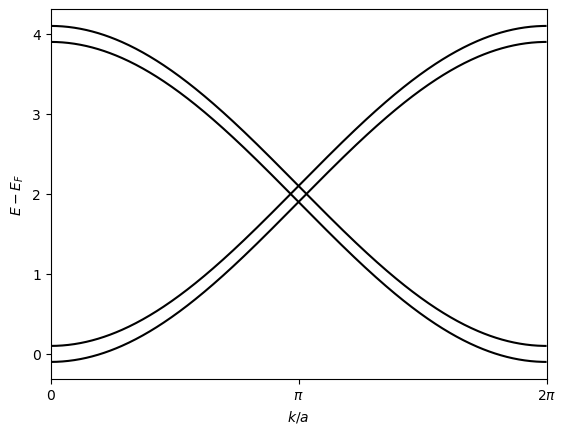

In [35]:
# Plot the band structure with mean field

hamiltonians = meanfi.tb_to_kgrid(h_mf, nk)
vals, vecs = np.linalg.eigh(hamiltonians)
plt.plot(ks, vals, c="k")
plt.xticks([0, np.pi, 2 * np.pi], ["$0$", r"$\pi$", r"$2\pi$"])
plt.xlim(0, 2 * np.pi)
plt.ylabel("$E - E_F$")
plt.xlabel("$k / a$")
plt.show()

### Check the spin structure

In [36]:
rho, _ = meanfi.density_matrix(h_mf, filling=filling, nk=51)

svals, tot_s = expectation_value_spins(rho)

In [37]:
print("spin on site 1:", svals[0])
print("spin on site 2:", svals[1])
print("total spin:", tot_s)

spin on site 1: -0.037346851383483926
spin on site 2: -0.037346849979180766
total spin: -0.07469370136266469


### Ideas what to play with

- Change the filling factor. The system is infinite now, so you can enter fractional filling factors. Does the band structure and the spin structure change?
- What happens if you change the size of the unit cell? Are results consistent?
- Can you extend this to a higher-dimensional Hubbard model?
- Any other ideas you can came up?

### Systematic study of gap size

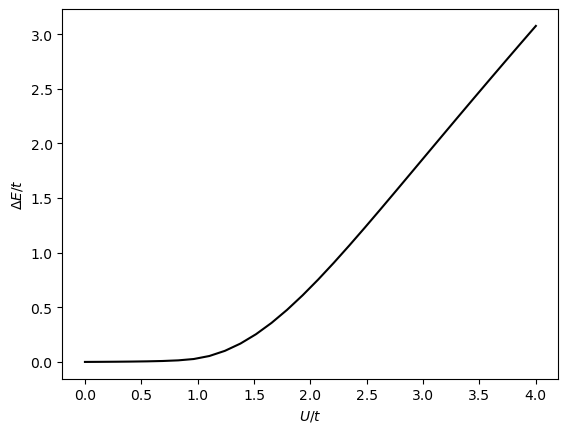

In [30]:
def compute_sol(U, h_0, nk, filling=2):
    h_int = {
        (0,): U * np.kron(np.eye(2), np.ones((2, 2))),
    }
    guess = meanfi.guess_tb(frozenset(h_int), len(list(h_0.values())[0]))
    full_model = meanfi.Model(h_0, h_int, filling)
    mf_sol = meanfi.solver(full_model, guess, nk=nk)
    return meanfi.add_tb(h_0, mf_sol)


def compute_gap(full_sol, nk_dense, fermi_energy=0):
    h_kgrid = meanfi.tb_to_kgrid(full_sol, nk_dense)
    vals = np.linalg.eigvalsh(h_kgrid)

    emax = np.max(vals[vals <= fermi_energy])
    emin = np.min(vals[vals > fermi_energy])
    return np.abs(emin - emax)


def compute_phase_diagram(
    Us,
    nk,
    nk_dense,
):
    gaps = []
    for U in Us:
        full_sol = compute_sol(U, h_0, nk)
        gaps.append(compute_gap(full_sol, nk_dense))

    return np.asarray(gaps, dtype=float)


Us = np.linspace(0, 4, 30, endpoint=True)
gaps = compute_phase_diagram(Us=Us, nk=200, nk_dense=200)

plt.plot(Us, gaps, c="k")
plt.xlabel("$U / t$")
plt.ylabel(r"$\Delta{E}/t$")
plt.show()

### Ideas what to play with
- Probably hard in the limited time: can you map out the phase diagram systematically? E.g. through computing the spin expectation values? Or by looking where gaps open?